In [82]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

In [83]:
# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)

In [84]:
data = pd.read_csv('E:/merged_data.csv')
df = data
X = []
Y = []
window_size = 100
for i in range(1, len(df) - window_size - 1, 1):
    first_feature = df.iloc[i, 1]
    second_feature = df.iloc[i, 2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append([(df.iloc[i + j, 1] - first_feature) / first_feature, (df.iloc[i + j, 2] - second_feature) / second_feature])
    temp2.append((df.iloc[i + window_size, 1] - first_feature) / first_feature)
    X.append(np.array(temp).reshape(100, 2))
    Y.append(np.array(temp2).reshape(1, 1))

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0], 1, 100, 2)
test_X = test_X.reshape(test_X.shape[0], 1, 100, 2)

model = tf.keras.Sequential()

In [86]:
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu', input_shape=(None, 100, 2))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

In [87]:
# LSTM layers with Attention
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Attention(return_sequences=True))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.3))

In [88]:
# Final layers
model.add(Dense(1, activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

In [89]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
history_dict = history.history
train_loss = history_dict['loss']
train_msle = history_dict['mse']

model.evaluate(test_X, test_Y)

Epoch 1/100
25/25 [==============================] - 59s 151ms/step - loss: 0.1742 - mse: 0.1742 - mae: 0.2826 - val_loss: 0.0459 - val_mse: 0.0459 - val_mae: 0.1713
Epoch 2/100
25/25 [==============================] - 4s 180ms/step - loss: 0.0589 - mse: 0.0589 - mae: 0.1676 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1328
Epoch 3/100
25/25 [==============================] - 7s 263ms/step - loss: 0.0401 - mse: 0.0401 - mae: 0.1364 - val_loss: 0.0543 - val_mse: 0.0543 - val_mae: 0.1544
Epoch 4/100
25/25 [==============================] - 3s 132ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1195 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1181
Epoch 5/100
25/25 [==============================] - 2s 92ms/step - loss: 0.0276 - mse: 0.0276 - mae: 0.1073 - val_loss: 0.0455 - val_mse: 0.0455 - val_mae: 0.1415
Epoch 6/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.0933 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.0990
Epoch 7/100

Epoch 51/100
25/25 [==============================] - 1s 28ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0526 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0510
Epoch 52/100
25/25 [==============================] - 1s 32ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0463 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0530
Epoch 53/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0575 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0511
Epoch 54/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0576 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0671
Epoch 55/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0490 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0506
Epoch 56/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0541 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0621
Epoch 57/1

7/7 [==============================] - 0s 11ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0457


[0.004473473876714706, 0.004473473876714706, 0.045678384602069855]

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
print('Mean Absolute Error (MAE): %f' % mae)

rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
print('Root Mean Squared Error (RMSE): %f' % rmse)

r2 = r2_score(test_Y.reshape(-1, 1), yhat_probs)
print('R2 Score: %f' % r2)

Mean Absolute Error (MAE): 0.045678
Root Mean Squared Error (RMSE): 0.066884
R2 Score: 0.991818


In [81]:
lstm_units = [100, 50]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for units in lstm_units:
    for dropout_rate in dropout_rates:
        model = tf.keras.Sequential()

        # CNN layers
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Flatten()))

        # LSTM layers with Attention
        model.add(Bidirectional(LSTM(units, return_sequences=True)))
        model.add(Attention(return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
        model.add(Dropout(dropout_rate))

        # Final layers
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

        model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=128, verbose=1, shuffle=True)

        # Predict probabilities for test set
        yhat_probs = model.predict(test_X, verbose=0)
        yhat_probs = yhat_probs[:, 0]

        # Calculate MAE and RMSE
        mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
        rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
        
        print(f"Units: {units}, Dropout: {dropout_rate}, Mean Absolute Error (MAE): {mae}, Root Mean Squared Error (RMSE): {rmse}")


Epoch 1/100
7/7 [==============================] - 68s 459ms/step - loss: 0.4224 - mse: 0.4224 - mae: 0.4278 - val_loss: 0.1317 - val_mse: 0.1317 - val_mae: 0.2810
Epoch 2/100
7/7 [==============================] - 1s 72ms/step - loss: 0.1420 - mse: 0.1420 - mae: 0.2888 - val_loss: 0.0920 - val_mse: 0.0920 - val_mae: 0.2211
Epoch 3/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0857 - mse: 0.0857 - mae: 0.2065 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1987
Epoch 4/100
7/7 [==============================] - 1s 82ms/step - loss: 0.0660 - mse: 0.0660 - mae: 0.1938 - val_loss: 0.0495 - val_mse: 0.0495 - val_mae: 0.1749
Epoch 5/100
7/7 [==============================] - 1s 73ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1705 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.1700
Epoch 6/100
7/7 [==============================] - 1s 101ms/step - loss: 0.0526 - mse: 0.0526 - mae: 0.1636 - val_loss: 0.0419 - val_mse: 0.0419 - val_mae: 0.1565
Epoch 7/100
7/7 [========

7/7 [==============================] - 0s 68ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0652 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0906
Epoch 52/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0725 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0872
Epoch 53/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0741 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0875
Epoch 54/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0774 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0916
Epoch 55/100
7/7 [==============================] - 1s 72ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0710 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0800
Epoch 56/100
7/7 [==============================] - 0s 69ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0709 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0803
Epoch 57/100
7/7 [=================

7/7 [==============================] - 17s 486ms/step - loss: 0.4561 - mse: 0.4561 - mae: 0.4406 - val_loss: 0.2488 - val_mse: 0.2488 - val_mae: 0.3558
Epoch 2/100
7/7 [==============================] - 0s 61ms/step - loss: 0.1741 - mse: 0.1741 - mae: 0.3155 - val_loss: 0.0935 - val_mse: 0.0935 - val_mae: 0.2208
Epoch 3/100
7/7 [==============================] - 0s 59ms/step - loss: 0.1172 - mse: 0.1172 - mae: 0.2240 - val_loss: 0.0731 - val_mse: 0.0731 - val_mae: 0.2003
Epoch 4/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0766 - mse: 0.0766 - mae: 0.2114 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.1805
Epoch 5/100
7/7 [==============================] - 0s 72ms/step - loss: 0.0626 - mse: 0.0626 - mae: 0.1747 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1702
Epoch 6/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.1739 - val_loss: 0.0439 - val_mse: 0.0439 - val_mae: 0.1617
Epoch 7/100
7/7 [=====================

7/7 [==============================] - 0s 62ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0762 - val_loss: 0.0125 - val_mse: 0.0125 - val_mae: 0.0845
Epoch 52/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0779 - val_loss: 0.0125 - val_mse: 0.0125 - val_mae: 0.0840
Epoch 53/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0759 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0789
Epoch 54/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0741 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0869
Epoch 55/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0771 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0847
Epoch 56/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0736 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0809
Epoch 57/100
7/7 [=================

KeyboardInterrupt: 

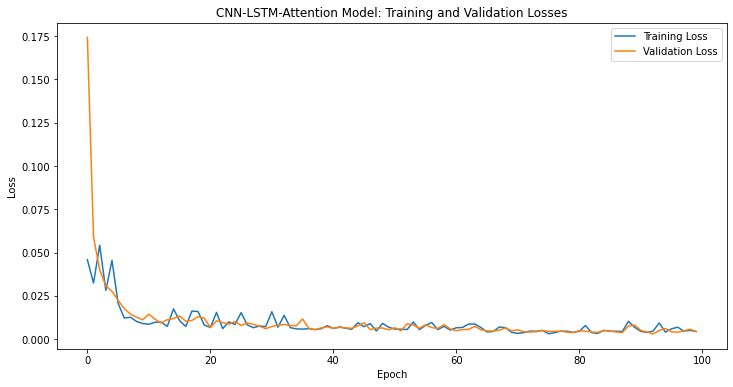

In [91]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.title('CNN-LSTM-Attention Model: Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
# Predict the values using the trained model
predictions = model.predict(test_X)

# Reverse the normalization process
def denormalize(value, first_value):
    return value * first_value + first_value

denormalized_predictions = np.empty_like(predictions)
denormalized_test_Y = np.empty_like(test_Y)

# Apply denormalization
for i in range(len(predictions)):
    first_value = df.iloc[i + window_size, 1]
    denormalized_predictions[i] = denormalize(predictions[i], first_value)
    denormalized_test_Y[i] = denormalize(test_Y[i], first_value)
    
# Compare denormalized predictions with actual values
for i in range(len(denormalized_predictions)):
    print(f"Prediction: {denormalized_predictions[i][0].item():.2f} | Actual: {denormalized_test_Y[i][0].item():.2f}")

7/7 [==============================] - 0s 15ms/step
Prediction: 6746.02 | Actual: 6613.27
Prediction: 8983.25 | Actual: 9033.39
Prediction: 12749.26 | Actual: 13135.16
Prediction: 3894.84 | Actual: 4025.56
Prediction: 6178.11 | Actual: 6247.53
Prediction: 5240.98 | Actual: 5628.80
Prediction: 4959.59 | Actual: 4461.00
Prediction: 6357.50 | Actual: 6531.16
Prediction: 8112.25 | Actual: 8053.58
Prediction: 7346.86 | Actual: 7510.40
Prediction: 5275.18 | Actual: 5102.34
Prediction: 4265.77 | Actual: 4403.05
Prediction: 5101.27 | Actual: 5060.37
Prediction: 11791.94 | Actual: 11494.41
Prediction: 12641.32 | Actual: 13003.65
Prediction: 11198.87 | Actual: 11637.80
Prediction: 5273.45 | Actual: 5137.61
Prediction: 9236.01 | Actual: 9025.71
Prediction: 8447.30 | Actual: 8757.21
Prediction: 20845.20 | Actual: 22141.90
Prediction: 6106.80 | Actual: 6073.39
Prediction: 24066.39 | Actual: 22573.27
Prediction: 7921.04 | Actual: 7045.58
Prediction: 17216.62 | Actual: 16866.17
Prediction: 22120.83 |

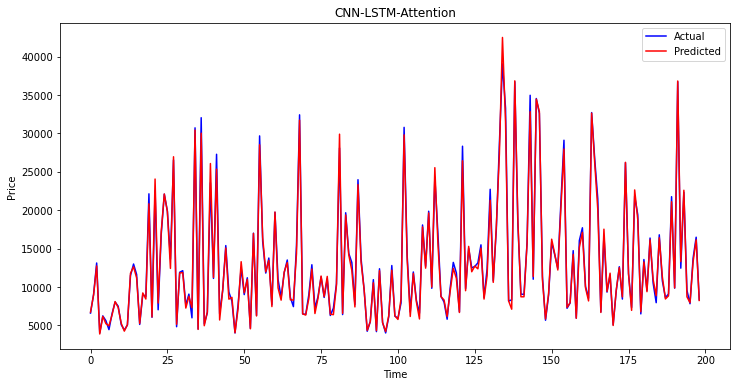

<Figure size 432x288 with 0 Axes>

In [93]:
# Flatten the denormalized_test_Y and denormalized_predictions arrays
denormalized_test_Y_flattened = denormalized_test_Y.flatten()
denormalized_predictions_flattened = denormalized_predictions.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_test_Y_flattened, label='Actual', color='blue')
plt.plot(denormalized_predictions_flattened, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('CNN-LSTM-Attention')
plt.show()
# Save the plot as an image file
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')